<a href="https://colab.research.google.com/github/SushilKokare/AtiNeu_Project/blob/main/Copy_of_ensembleYT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pip install Augmentor

In [ ]:
# import Augmentor

In [ ]:
# Here write augmentiation part

In [6]:
# !pip install tensorflow-gpu

In [7]:
# !nvidea-smi

In [6]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten, Dropout, Input, Average, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import BatchNormalization, MaxPooling2D

In [7]:
train_dir = '/content/drive/MyDrive/AtiNeu Project/Data/MRI/Brain_Data_Organised/Train'
test_dir = '/content/drive/MyDrive/AtiNeu Project/Data/MRI/Brain_Data_Organised/Test'

In [8]:
input_shape = (225,225)
batch_size = 10

In [9]:
train_ds1 = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed = 123,
    image_size=input_shape,
    batch_size = batch_size,
    #color_mode = 'grayscale'
)

Found 2251 files belonging to 2 classes.


In [10]:
test_ds1 = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed = 123,
    image_size = input_shape,
    batch_size = batch_size,
    #color_mode = 'grayscale'
)

Found 250 files belonging to 2 classes.


In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds1.map(lambda x,y: (normalization_layer(x),y))
image_batch = labels_batch = next(iter(normalized_ds))
first_img = image_batch[0]
print(np.min(first_img),np.max(first_img))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 1.0


In [13]:
type(normalization_layer)

keras.layers.preprocessing.image_preprocessing.Rescaling

In [14]:
del normalization_layer

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds1.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_ds = train_ds1.cache().prefetch(buffer_size = AUTOTUNE)

In [16]:
del AUTOTUNE
del train_ds1
del test_ds1

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121

In [18]:
RN50_base_model = ResNet50(
    input_shape = (225,225,3),
    weights = 'imagenet',
    include_top = False
)

In [19]:
# Freeze  the first 10 layers
for layer in RN50_base_model.layers[:10]:
  layer.trainable = False

x = RN50_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(2,activation='sigmoid')(x)

model1 = Model(inputs = RN50_base_model.inputs, outputs = predictions)

In [20]:
del RN50_base_model

In [21]:
DN121_base_model = DenseNet121(
    input_shape = (225,225,3),
    weights = 'imagenet',
    include_top = False
)

In [22]:
for layer in DN121_base_model.layers[:10]:
  layer.trainable = False

x = DN121_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(2,activation='sigmoid')(x)

model2 = Model(inputs = DN121_base_model.inputs, outputs = predictions)

In [23]:
del DN121_base_model

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [25]:
# checkpoint to save best model per epoch

model_filepath = '/content/drive/MyDrive/AtiNeu Project/model-{epoch:02d} - {val_accuracy: .4f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

In [26]:
# compilations of models

In [32]:
model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [33]:
model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [34]:
history1 = model1.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 3,
    callbacks=[checkpoint]
)

Epoch 1/3
226/226 [==============================] - ETA: 0s - loss: 0.7847 - accuracy: 0.6117
Epoch 1: val_accuracy improved from -inf to 0.63350, saving model to /content/drive/MyDrive/AtiNeu Project/model-01 -  0.6335.hdf5
226/226 [==============================] - 115s 172ms/step - loss: 0.7847 - accuracy: 0.6117 - val_loss: 4.9152 - val_accuracy: 0.6335
Epoch 2/3
226/226 [==============================] - ETA: 0s - loss: 0.6208 - accuracy: 0.6331
Epoch 2: val_accuracy did not improve from 0.63350
226/226 [==============================] - 34s 153ms/step - loss: 0.6208 - accuracy: 0.6331 - val_loss: 3.3557 - val_accuracy: 0.6335
Epoch 3/3
226/226 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.6504
Epoch 3: val_accuracy improved from 0.63350 to 0.63483, saving model to /content/drive/MyDrive/AtiNeu Project/model-03 -  0.6348.hdf5
226/226 [==============================] - 38s 169ms/step - loss: 0.6029 - accuracy: 0.6504 - val_loss: 0.9671 - val_accuracy: 0.6

In [ ]:
#  import gc
#  gc.collect()

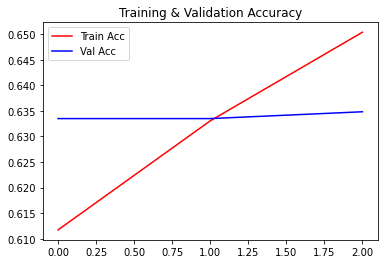

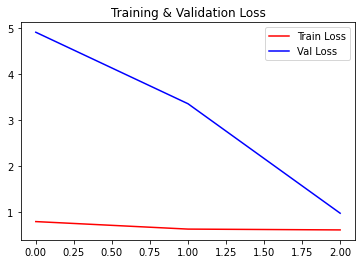

In [82]:
import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label='Train Acc')
plt.plot(epochs,val_acc,'b',label='Val Acc')
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Val Loss')
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

In [37]:
history2 = model2.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 3,
    callbacks=[checkpoint]
)

Epoch 1/3
226/226 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.5908
Epoch 1: val_accuracy did not improve from 0.63483
226/226 [==============================] - 103s 179ms/step - loss: 0.7759 - accuracy: 0.5908 - val_loss: 447.2368 - val_accuracy: 0.6335
Epoch 2/3
226/226 [==============================] - ETA: 0s - loss: 0.5748 - accuracy: 0.6948
Epoch 2: val_accuracy did not improve from 0.63483
226/226 [==============================] - 37s 163ms/step - loss: 0.5748 - accuracy: 0.6948 - val_loss: 3.1129 - val_accuracy: 0.6335
Epoch 3/3
226/226 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.7308
Epoch 3: val_accuracy improved from 0.63483 to 0.72990, saving model to /content/drive/MyDrive/AtiNeu Project/model-03 -  0.7299.hdf5
226/226 [==============================] - 39s 171ms/step - loss: 0.5334 - accuracy: 0.7308 - val_loss: 0.5552 - val_accuracy: 0.7299


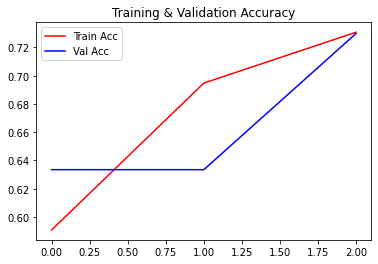

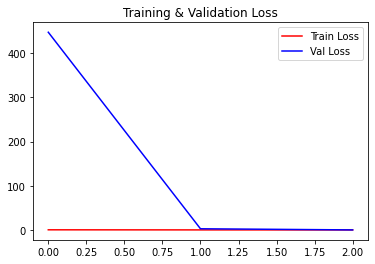

In [83]:
import matplotlib.pyplot as plt

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label='Train Acc')
plt.plot(epochs,val_acc,'b',label='Val Acc')
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Val Loss')
plt.title("Training & Validation Loss")
plt.legend()

plt.show()

In [39]:
# Combining Model

In [40]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Average

In [50]:
# youtube model name = /model-01-0.9044.hdf5 

model_1 = load_model('/content/drive/MyDrive/AtiNeu Project/model-03 -  0.6348.hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')

In [53]:
# youtube model name = model-04-0.0156.hdf5

model_2 = load_model('/content/drive/MyDrive/AtiNeu Project/model-03 -  0.7299.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

In [73]:
models = [model_1,model_2]
model_input = Input(shape=(225,225,3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input,outputs=ensemble_output,name='ensemble')

In [74]:
ensemble_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                               metrics=['accuracy'])

In [75]:
history = ensemble_model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=5
)

Epoch 1/5
226/226 [==============================] - 164s 301ms/step - loss: 0.5535 - accuracy: 0.7201 - val_loss: 5.6447 - val_accuracy: 0.6335
Epoch 2/5
226/226 [==============================] - 66s 294ms/step - loss: 0.5003 - accuracy: 0.7503 - val_loss: 3.4069 - val_accuracy: 0.6344
Epoch 3/5
226/226 [==============================] - 67s 297ms/step - loss: 0.4653 - accuracy: 0.7752 - val_loss: 0.5103 - val_accuracy: 0.7819
Epoch 4/5
226/226 [==============================] - 68s 301ms/step - loss: 0.3797 - accuracy: 0.8490 - val_loss: 0.3376 - val_accuracy: 0.8467
Epoch 5/5
226/226 [==============================] - 68s 301ms/step - loss: 0.3118 - accuracy: 0.8716 - val_loss: 0.1359 - val_accuracy: 0.9440


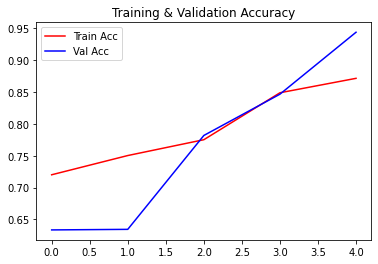

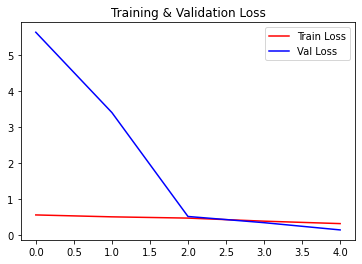

In [80]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label='Train Acc')
plt.plot(epochs,val_acc,'b',label='Val Acc')
plt.title("Training & Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Val Loss')
plt.title("Training & Validation Loss")
plt.legend()

plt.show()